## Regressão simbólica aplicada ao modelo populacional de Gompertz

In [1]:
# Impot de bibliotecas 

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import gompertz, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)


pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                fitness                	                  size                 
   	      	---------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg 	gen	min	nevals	std    
0  	1000  	55.9493	0  	2.31984	1000  	568.366	3.88	0  	2  	1000  	1.66241
1  	514   	27.0584	1  	2.31984	514   	328.675	3.759	1  	1  	514   	1.63857
2  	520   	13.3421	2  	2.31984	520   	14.0683	3.635	2  	1  	520   	1.64371
3  	505   	5.37623e+40	3  	1.66057	505   	1.20096e+42	3.613	3  	1  	505   	1.6659 
4  	534   	2.02666e+41	4  	1.66057	534   	6.40566e+42	3.755	4  	1  	534   	1.69852
5  	529   	1.00319e+41	5  	1.4593 	529   	2.47097e+42	4.115	5  	1  	529   	1.6431 
6  	540   	10.6605    	6  	1.4593 	540   	25.0463    	4.417	6  	1  	540   	1.54114
7  	491   	43522      	7  	1.4593 	491   	1.22242e+06	4.747	7  	1  	491   	1.52151
8  	502   	84254.8    	8  	1.66057	502   	1.7289e+06 	5.128	8  	1  	502   	1.55423
9  	506   	inf        

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


10 	516   	inf        	10 	1.66057	516   	nan        	5.668	10 	1  	516   	1.51055
11 	520   	inf        	11 	1.66057	520   	nan        	5.845	11 	1  	520   	1.40889
12 	494   	inf        	12 	1.66057	494   	nan        	5.922	12 	1  	494   	1.33638
13 	510   	27159.8    	13 	1.66057	510   	857795     	6.026	13 	1  	510   	1.18967
14 	531   	inf        	14 	1.66057	531   	nan        	6.066	14 	1  	531   	1.15916
15 	460   	45.6211    	15 	1.66057	460   	895.008    	6.099	15 	1  	460   	1.03595
16 	510   	47.5937    	16 	1.66057	510   	895.409    	6.052	16 	1  	510   	1.14074
17 	560   	17.0785    	17 	1.66057	560   	56.9186    	6.014	17 	2  	560   	1.0285 
18 	503   	inf        	18 	1.66057	503   	nan        	6.072	18 	1  	503   	1.17593
19 	535   	74.775     	19 	1.66057	535   	1781.5     	6.037	19 	1  	535   	1.08427
20 	521   	inf        	20 	1.66057	521   	nan        	6.11 	20 	1  	521   	1.12334
21 	539   	17.543     	21 	1.66057	539   	56.4428    	6.098	21 	1  	539   	1.14123
22 	

C:\JupyterLab\Regressão simbolica\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)


190	503   	inf        	190	0.926418	503   	nan        	7.186	190	2  	503   	1.49446
191	493   	inf        	191	0.926418	493   	nan        	7.191	191	1  	493   	1.6354 
192	501   	inf        	192	0.926418	501   	nan        	7.162	192	1  	501   	1.50125
193	474   	inf        	193	0.926418	474   	nan        	7.212	193	2  	474   	1.46118
194	530   	inf        	194	0.926418	530   	nan        	7.19 	194	1  	530   	1.58616
195	545   	inf        	195	0.926418	545   	nan        	7.269	195	3  	545   	1.5494 
196	530   	inf        	196	0.926418	530   	nan        	7.303	196	1  	530   	1.68795
197	561   	inf        	197	0.926418	561   	nan        	7.307	197	3  	561   	1.74607
198	454   	inf        	198	0.926418	454   	nan        	7.292	198	1  	454   	1.64157
199	489   	inf        	199	0.926418	489   	nan        	7.294	199	1  	489   	1.59423
200	506   	inf        	200	0.926418	506   	nan        	7.299	200	1  	506   	1.64305
201	483   	inf        	201	0.926418	483   	nan        	7.303	201	1  	483   	

C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_44992/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


413	496   	inf        	413	0.926418	496   	nan        	11.178	413	2  	496   	2.67214
414	514   	inf        	414	0.926418	514   	nan        	11.149	414	3  	514   	2.75441
415	521   	inf        	415	0.926418	521   	nan        	11.147	415	1  	521   	2.83397
416	490   	inf        	416	0.926418	490   	nan        	11.143	416	1  	490   	2.52201
417	525   	inf        	417	0.926418	525   	nan        	11.131	417	1  	525   	2.78816
418	480   	inf        	418	0.926418	480   	nan        	11.156	418	1  	480   	2.40866
419	488   	inf        	419	0.926418	488   	nan        	11.175	419	1  	488   	2.60046
420	555   	inf        	420	0.926418	555   	nan        	11.23 	420	1  	555   	2.69687
421	503   	inf        	421	0.926418	503   	nan        	11.177	421	1  	503   	2.46408
422	455   	inf        	422	0.926418	455   	nan        	11.252	422	1  	455   	2.4772 
423	501   	inf        	423	0.926418	501   	nan        	11.164	423	3  	501   	2.73223
424	526   	inf        	424	0.926418	526   	nan        	11.144	424

In [11]:
for i in hof.items:
    print(str(i))
    print()

Div(add(Exp(sub(0, t)), add(Exp(t), 1)), Exp(t))

Div(add(add(Exp(t), 1), Exp(neg(t))), Exp(t))

Div(add(Exp(Div(t, -1)), add(Exp(t), 1)), Exp(t))

Div(add(Exp(neg(t)), add(1, Exp(t))), Exp(t))

Div(add(Exp(neg(t)), add(Exp(t), 1)), Exp(t))



### Reportando o melhor individuo encontrado

Div(add(Exp(sub(0, t)), add(Exp(t), 1)), Exp(t))


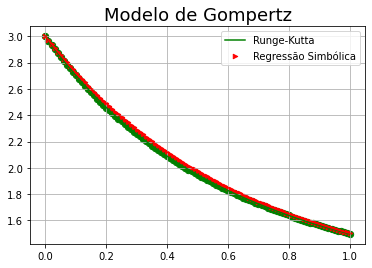

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

1 + exp(-t) + exp(-2*t)